# Notebook to pool lineprofiles, calculate peak distance and plot Histograms

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imsave
from scipy import signal
from scipy import misc
import scipy.fftpack
from scipy import stats
from scipy import signal
import os

## Define Path and Files

In [6]:
path=r"enter folder path here" # enter path to parent folder. data for sigle experiments is stored in subfolders, e.g. N=3 --> 3 subfolders


folders=os.listdir(path)

allfiles=[]
folderlist=[]
files=[]
for i in folders:
    
    tmp=os.listdir(path+i)
    for f in tmp:
        if (".csv" in f)==True: 
            files=files+[f]
            folderlist=folderlist+[i]
allfiles=pd.DataFrame([folderlist,files]).T
allfiles.columns=["folder","file"]

# define splitting function

In [7]:
def split(matrix,identifyer,axis):
    splitted=matrix.filter(like=identifyer,axis=axis)
    return splitted

# define binning function

In [8]:
from scipy.stats import binned_statistic

def binData(inData,firstcol,lastcol,minbin,maxbin,nbins):
    myArray=inData.as_matrix()
    
    numrows = len(myArray)
    numcols = len(myArray[0]) #[0] for cols. otherwise rows
    if (lastcol=="max"):
        lastcol=numcols

    for j in range(firstcol, lastcol):
       

        data = myArray[:,j]
        bin_means = binned_statistic(data, data, statistic="count", bins=nbins, range=(minbin, maxbin))[0]
        bin_edges= binned_statistic(data, data, statistic='count', bins=nbins, range=(minbin, maxbin))[1]
        binnumber= binned_statistic(data, data, statistic='count', bins=nbins, range=(minbin, maxbin))[2]
        bin_middle=bin_edges[0:len(bin_edges)-1]+((maxbin-minbin)/nbins/2)

        bin_means = np.nan_to_num(bin_means)
        bin_means=bin_means.tolist()       
        
        if (j==0):
            allbins = np.vstack((bin_middle, bin_means))
        else:
            allbins = np.vstack((allbins, bin_means))
        
    allbins=allbins.T
    

    
    matrix=pd.DataFrame(allbins).set_index(0)
    matrix.columns=inData.columns[firstcol:lastcol]
   

    

    return(matrix)



# Find Local Maxima

In [ ]:
distances=[]
foldercolumn=[]
filecolumn=[]
profilenumbercolumn=[]
fused=[]

counter=0

Y0traces=[]
Y1traces=[]

Y0maxima=[]
Y1maxima=[]

for j in range(0,len(allfiles["folder"])):

    name=path+allfiles["folder"]+"\\"+allfiles["file"]
    matrix=pd.read_csv(name[j])
    matrixY=split(matrix,"Y",1)


    fig=plt.figure()
    for i in range(0,matrixY.shape[1]): 

        trace=matrixY.T.values[i]
        smoothed=scipy.ndimage.gaussian_filter(trace, 0, mode='reflect')        
        
        
        maxima=np.array(signal.argrelmax(smoothed,mode='clip'))#calculate maxima


            
        
        
        
        ########REMOVE SMALL PEAKS###################
        filtered=[]
        for k in maxima[0]:
            window=30
            delta=5
            tmp=np.arange(k-window,k+window)
            tmp=tmp[tmp>=0]
            tmp=tmp[tmp<len(trace)]
  
            minI=np.min(trace[tmp])#calculate minimum intensity in window
            if ((trace[k]>delta+minI) == True) :
                filtered=filtered+[k]
        maxima=np.array([filtered])
        
        if(i==0):
            print(0)
            Y0traces=Y0traces+[trace.tolist()]
            Y0maxima=Y0maxima+maxima.tolist()
        if(i==1):
            print(1)
            Y1traces=Y1traces+[trace.tolist()]
            Y1maxima=Y1maxima+maxima.tolist()
        
        
        ##########PLOT EVERYTHING#######################      
        try:
            plt.scatter(maxima,trace[maxima[0]], s=600, c='red', marker='x')
        except:
            pass

        plt.plot(trace)
        plt.plot(smoothed)
        plt.title(name[j])
        plt.xlabel('pixels')
        plt.ylabel('intensity')     

        parent, child = os.path.split(path.strip("\\"))
        newPath=parent+"/analysis/"+"/singleTrace/"
        if (os.path.exists(newPath)==False):
            os.makedirs(newPath)
        
        
        if (len(maxima)>1):
            zwerg=maxima[1]-maxima[0]
        else:zwerg="NaN"
            
        
        
        

        
        
        counter=counter+1
    plt.show()
    foldercolumn=foldercolumn+[allfiles["folder"][j]]
    filecolumn=filecolumn+[allfiles["file"][j]]
    fused=fused+[allfiles["file"][j]+allfiles["folder"][j]]
    fig.savefig(newPath+allfiles["folder"][j]+allfiles["file"][j]+str(round(i))+".png")

# Calculate Distance from highest peaks

In [10]:
highestY0max=pd.DataFrame(Y0maxima).T.max().tolist()
highestY1max=pd.DataFrame(Y1maxima).T.max().tolist()

distances=abs(np.subtract(highestY0max,highestY1max)).tolist()
pixsize=0.025
umdistances=np.array(distances)*pixsize

# Extract Genotype from Names, calculate distance in µm and assemble dataframe

In [11]:
genotype=[]
for i in range(0,len(fused)):
    if ("20180302_1" in fused[i]
       or "20180328_8" in fused[i]
        or "20180328_15" in fused[i]
        or "20180328_18" in fused[i]
        or "20180328_12" in fused[i]
        or "20180419_19" in fused[i]
        or "20180419_24" in fused[i]
        or "20180419_436" in fused[i]
       
       
       ):
        #print(fused[i])
        genotype=genotype+["WT"]
    elif ("20180302_2" in fused[i]
        or "20180302_4" in fused[i]
        or "20180302_6" in fused[i]  
          or "20180328_14" in fused[i]
          or "20180328_16" in fused[i]
          or "20180328_17" in fused[i]
       ):
        genotype=genotype+["KO"]
        
    else:
        genotype=genotype+["notSpecified"]


In [12]:
output=pd.DataFrame([foldercolumn,
                     filecolumn,
                     genotype,
                     distances,
                     umdistances.tolist()]).T


output.columns=["folder",
                "title",
                "genotype",
                "cross-channel distance (pixels)",
                "cross-channel distance (µm)", 
                ]

#output.index.values=matrix["X0"].values
output.to_csv(parent+"\\measurements.xls",sep="\t")
output.set_index("folder", inplace=True)
output.head()

,title,genotype,cross-channel distance (pixels),cross-channel distance (µm)
folder,,,,
Values_20180302_1,Values_20180302_1_002_1.csv,WT,4,0.1
Values_20180302_1,Values_20180302_1_002_2.csv,WT,3,0.075
Values_20180302_1,Values_20180302_1_002_3.csv,WT,3,0.075
Values_20180302_1,Values_20180302_1_002_4.csv,WT,6,0.15
Values_20180302_1,Values_20180302_1_002_5.csv,WT,4,0.1


# Divide Dataset into WT vs KO

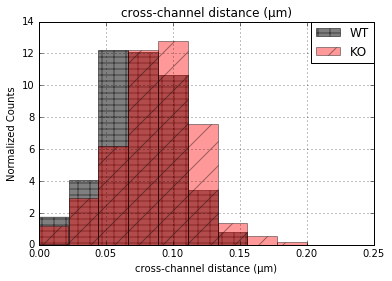

In [33]:
tmp=output
WT=tmp[output["genotype"]=="WT"]
KO=tmp[output["genotype"]=="KO"]

bins=np.linspace(0,0.2,10)
fig=plt.figure()
WT["cross-channel distance (µm)"].hist(color="black", alpha=0.5, hatch="+-", label ="WT", bins=bins,normed=True)
KO["cross-channel distance (µm)"].hist(color="red", alpha=0.4, hatch="/", edgecolor="black" ,label="KO",bins=bins,normed=True)
plt.title("cross-channel distance (µm)")
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
plt.xlabel('cross-channel distance (µm)')
plt.ylabel('Normalized Counts')
plt.show()
fig.savefig(parent+"\\cross-channel distance (µm).png")
fig.savefig(parent+"\\cross-channel distance (µm).eps", format='eps')
fig.savefig(parent+"\\cross-channel distance (µm).pdf", format='pdf')

In [14]:
mice=list(set(output.index))

distance_means=[]

for i in range (0,len(mice)):

    tmp=output.loc[mice[i]]

    distance_means=distance_means+[np.mean(tmp["cross-channel distance (µm)"])]


In [15]:
#resort the data

mice=list(set(output.index))

umdistance_means=[]
all_umdistances=[]

for i in range (0,len(mice)):

    tmp=output.loc[mice[i]]
    umdistance_means=umdistance_means+[np.mean(tmp["cross-channel distance (µm)"])]
    all_umdistances=all_umdistances+[tmp["cross-channel distance (µm)"].values]

   

    
#save all means
allMeans=pd.DataFrame([umdistance_means])
allMeans.columns=mice
allMeans.index=["distance_means (µm)"]
allMeans.T.to_csv(parent+"\\Means.xls",sep="\t")

    


# bin and save binned data
tmp=pd.DataFrame(all_umdistances).T
tmp.columns=mice
binnedDistances=binData(tmp,0,"max",0,0.2,10)
binnedDistances.to_csv(parent+"\\binnedDistances.xls",sep="\t")

C:\Niclas_Programme\Miniconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
